# Курсовой проект по курсу: Библиотеки Python для Data Science. Продолжение

## Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

## Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

## Метрика качества

F1-score (sklearn.metrics.f1_score)

## Требования к решению

Целевая метрика

F1 > 0.5 
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

# Обзор данных <a name='index'>

Описание датасета:

* **[Home Ownership](#1_feature)** - домовладение
* **[Annual Income](#2_feature)** - годовой доход
* **[Years in current job](#3_feature)** - количество лет на текущем месте работы
* **[Tax Liens](#4_feature)** - налоговые обременения
* **[Number of Open Accounts](#5_feature)** - количество открытых счетов
* **[Years of Credit History](#6_feature)** - количество лет кредитной истории
* **[Maximum Open Credit](#7_feature)** - наибольший открытый кредит
* **[Number of Credit Problems](#8_feature)** - количество проблем с кредитом
* **[Months since last delinquent](#9_feature)** - количество месяцев с последней просрочки платежа
* **[Bankruptcies](#10_feature)** - банкротства
* **[Purpose](#11_feature)** - цель кредита
* **[Term](#12_feature)** - срок кредита
* **[Current Loan Amount](#13_feature)** - текущая сумма кредита
* **[Current Credit Balance](#14_feature)** - текущий кредитный баланс
* **[Monthly Debt](#15_feature)** - ежемесячный долг
* **[Credit Score](#16_feature)** - кредитный рейтинг
* **[Credit Default](#17_feature)**- факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
* **[Новый признак](#new)** - вместо `Tax Liens`, `Number of Credit Problems` и `Bankruptcies` делаем один признак, а
`Tax Liens`, `Number of Credit Problems` и `Bankruptcies` исключаем

## Загрузка

In [161]:
import warnings
warnings.simplefilter('ignore')

In [162]:
 !pip install xgboost
 !pip install lightgbm
 !pip install catboost

In [163]:
# Загружаем библиотеки:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve

# Алгоритмы кластеризации:

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Метрика F1:

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Для статистики:

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

In [164]:
# Загрузка наборов данных:
TRAIN_DATASET_PATH = r'C:\course_project\course_project_train.csv'
TEST_DATASET_PATH = r'C:\course_project\course_project_test.csv'
df = pd.read_csv(TRAIN_DATASET_PATH)
print(f"Train:\t{df.shape[0]}\t lines and {df.shape[1]} features")
df_test = pd.read_csv(TEST_DATASET_PATH)
print(f'Test:\t{df_test.shape[0]}\t lines and {df_test.shape[1]} features')

Train:	7500	 lines and 17 features
Test:	2500	 lines and 16 features


In [165]:
# Добавляем в тренировочный набор данных поле ID
df['ID'] = df.index.tolist()

In [166]:
df.head(100)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Home Mortgage,805828.0,9 years,0.0,8.0,20.5,657360.0,0.0,38.0,0.0,debt consolidation,Short Term,199936.0,250933.0,13565.0,740.0,0,95
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1,96
97,Rent,840541.0,6 years,0.0,6.0,14.8,427372.0,0.0,NaN,0.0,business loan,Short Term,99999999.0,1102.0,483.0,751.0,0,97
98,Rent,1242087.0,NaN,0.0,17.0,20.6,613954.0,1.0,36.0,1.0,debt consolidation,Short Term,196130.0,181336.0,16251.0,711.0,1,98


In [167]:
df.shape

(7500, 18)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [170]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.50,209323.0,360406.25,6.506797e+06


## Пропуски

In [171]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [172]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

## Служебные функции

In [173]:
# функция показывает корреляцию между двумя группами одного признака в отношении целевого признака. 
# Если результат больше 0.05 - можно объединять в один
def corr_(val, x1, x2):
    pay1_and_target_s = df.loc[df[val].isin([x1, x2]), ['ID', val, 'Credit Default']]#.sample(1000)
    table = pay1_and_target_s.pivot_table(values='ID', index=val, columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(p)
    
    
# метрики
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def mis_values_report(df):
    '''Функция считает и выводит пропущенные значения столбцов датафрейма'''
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', ascending=False).round(1)
    print('Датафрейм имеет ' + str(df.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + ' столбцов имеют пропущенные значения')
    return report_columns


def hist_qq(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df[target_name].hist()
    plt.subplot(122)
    probplot(df[target_name],dist='norm',plot=plt)

    plt.show()
    

# # балансеровка целевой переменной
# def balance_df_by_target(df, target_name):

#     target_counts = df[target_name].value_counts()

#     major_class_name = target_counts.argmax()
#     minor_class_name = target_counts.argmin()

#     disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

#     for i in range(disbalance_coeff):
#         sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
#         df = df.append(sample, ignore_index=True)

#     return df.sample(frac=1) 

# Балансировка целевой переменной
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [174]:
mis_values_report(df)

Датафрейм имеет 18 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


# Обработка данных

## Home Ownership - домовладение<a name="1_feature"></a>

[Обзор данных](#index)

In [175]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

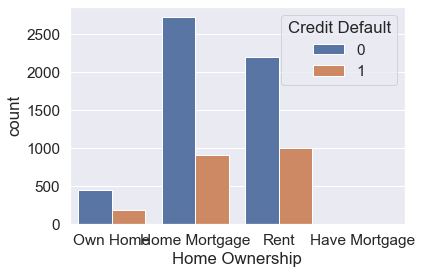

In [177]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.show()

In [178]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

## Annual Income - годовой доход<a name="2_feature"></a>

[Обзор данных](#index)

In [179]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

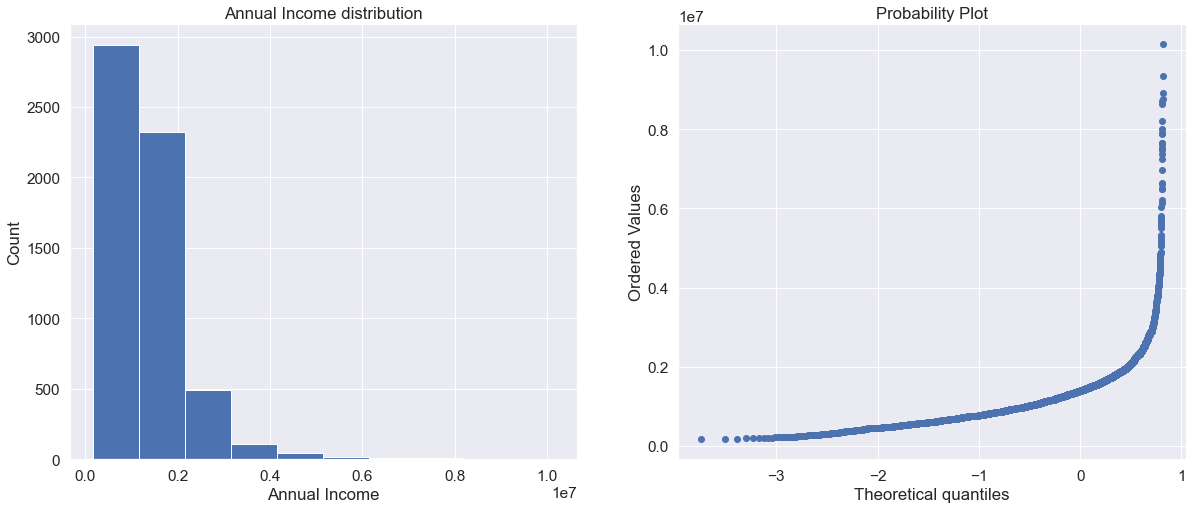

In [180]:
hist_qq('Annual Income')

In [181]:
# df.loc[df['Annual Income'].isnull(), 'Annual Income'] = 0
# df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = 0

## Заполняем пропуски и выбросы при помощи Линейной Регрессии

In [182]:
# df.loc[(df['Annual Income'] > df['Annual Income'].quantile(.95)), :].shape

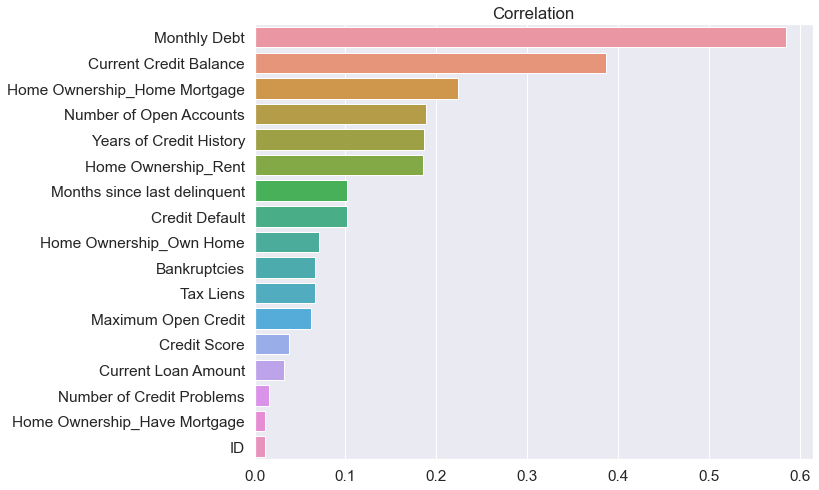

In [183]:
# смотрим, как коррелируют признаки с 'Annual Income'

FEATURE_NAMES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = df[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [184]:
# для обучения выбираем 7 наиболее влияющих признаков (8-й признак имеет много null)
TARGET_FEATURE = list(corr_Annual_Income.index[0:6])

In [185]:
# отбираем набор данных для обучения
data = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]#.sample(2000)
data

,Monthly Debt,Current Credit Balance,Home Ownership_Home Mortgage,Number of Open Accounts,Years of Credit History,Home Ownership_Rent,Annual Income
0,7914.0,47386.0,0,11.0,26.3,0,482087.0
1,18373.0,394972.0,0,15.0,15.3,0,1025487.0
2,13651.0,308389.0,1,11.0,35.0,0,751412.0
3,11338.0,95855.0,0,8.0,22.5,0,805068.0
4,7180.0,93309.0,0,13.0,13.6,1,776264.0
...,...,...,...,...,...,...,...
7491,61150.0,108889.0,1,18.0,21.3,0,2833185.0
7493,27562.0,167428.0,0,14.0,16.5,1,1257610.0
7495,1900.0,73492.0,0,3.0,8.5,1,402192.0
7496,12783.0,456399.0,1,10.0,26.5,0,1533984.0


In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly Debt                  5943 non-null   float64
 1   Current Credit Balance        5943 non-null   float64
 2   Home Ownership_Home Mortgage  5943 non-null   uint8  
 3   Number of Open Accounts       5943 non-null   float64
 4   Years of Credit History       5943 non-null   float64
 5   Home Ownership_Rent           5943 non-null   uint8  
 6   Annual Income                 5943 non-null   float64
dtypes: float64(5), uint8(2)
memory usage: 290.2 KB


In [187]:
%%time

# учимся на Регрессии

model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

Wall time: 4min 17s


LogisticRegression()

In [188]:
# заполняем пропуски на основе обученной модели

df.loc[(df['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df_test.loc[(df_test['Annual Income'].isnull()), TARGET_FEATURE])

In [189]:
# Посмотрим, какое распределение получилось

shapiro(df['Annual Income'])

ShapiroResult(statistic=0.7572181224822998, pvalue=0.0)

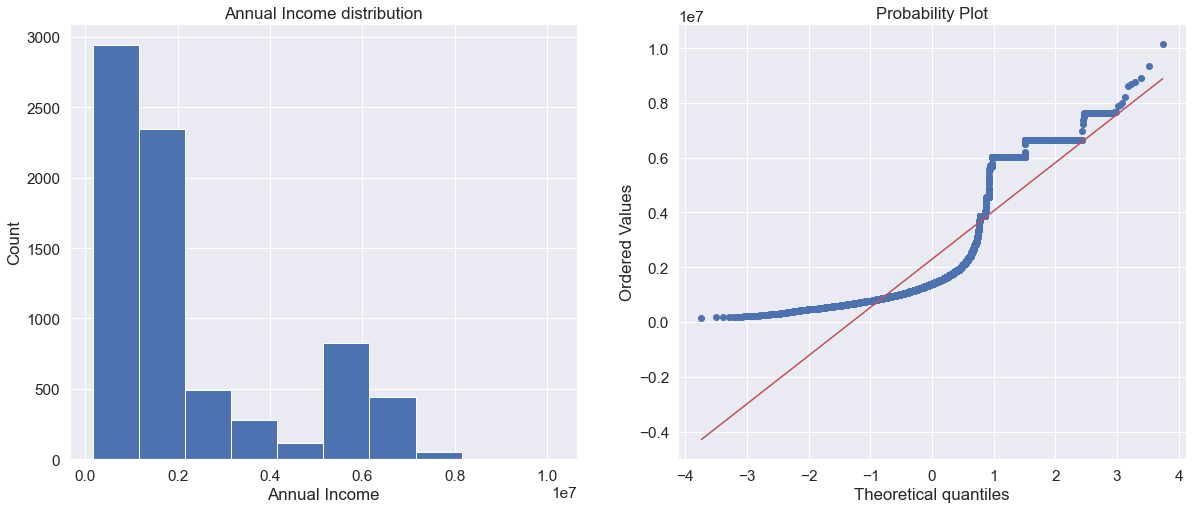

In [190]:
hist_qq('Annual Income')

In [191]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]#.sample(1000)
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, ['Annual Income']]

In [192]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=5499269.0, pvalue=0.011342310697895723)

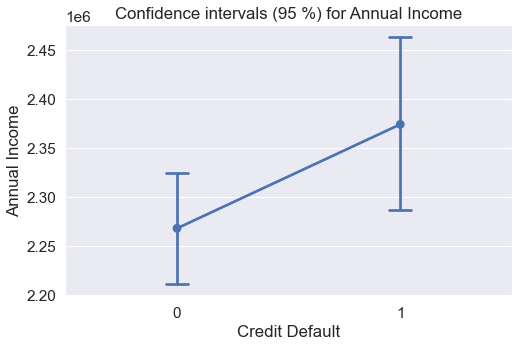

In [193]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

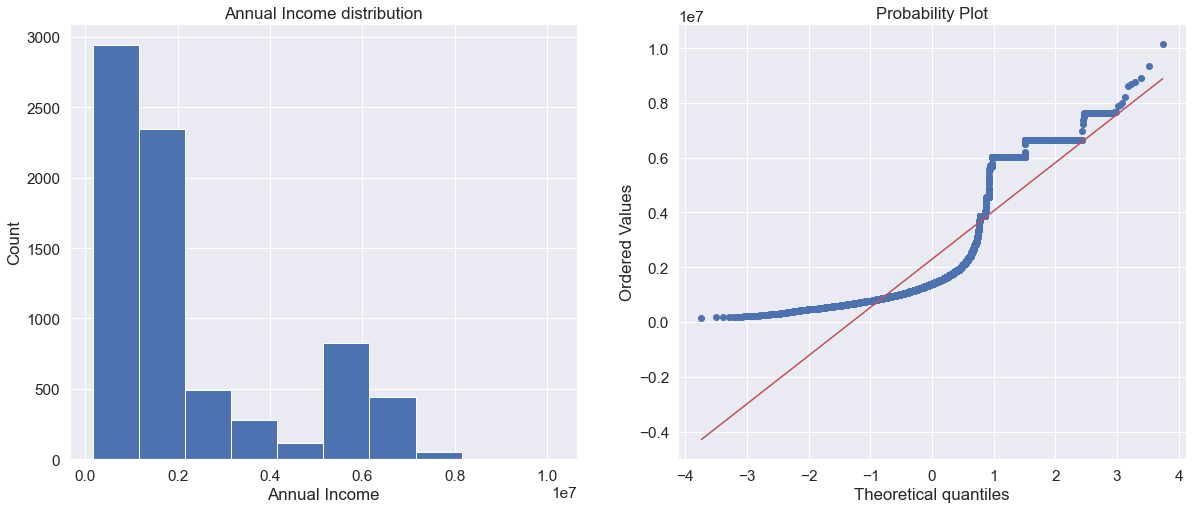

In [194]:
hist_qq('Annual Income')

In [195]:
# обрезаем хвост

df.loc[df['Annual Income'] > df['Annual Income'].quantile(.99), ['Annual Income']] =\
            df['Annual Income'].quantile(.99)  #df['Annual Income'].median()

df_test.loc[df_test['Annual Income'] > df_test['Annual Income'].quantile(.99), ['Annual Income']] = \
            df_test['Annual Income'].quantile(.99) #df_test['Annual Income'].median()

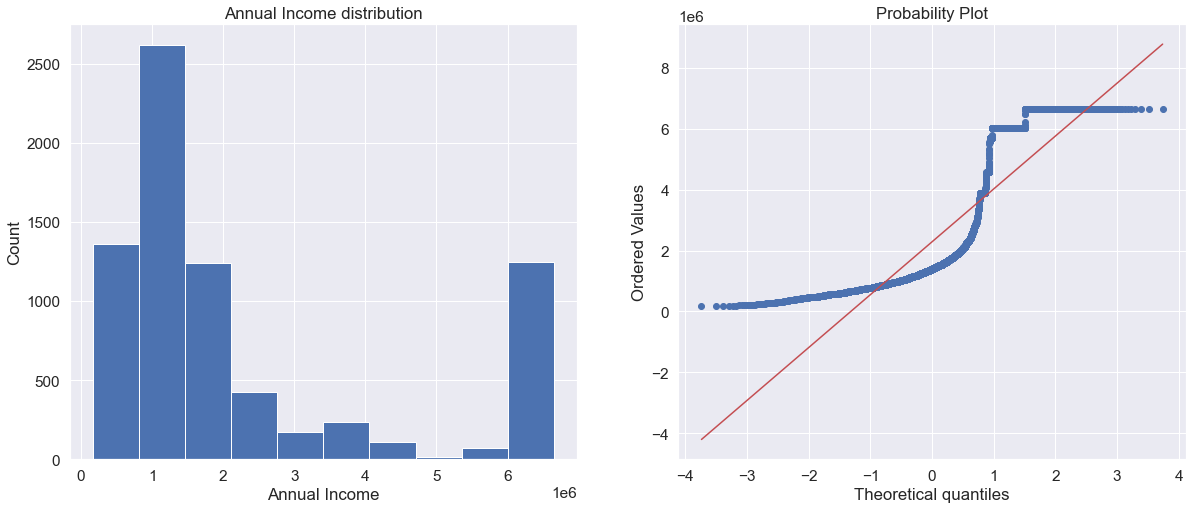

In [196]:
hist_qq('Annual Income')

## Years in current job - количество лет на текущем месте работы<a name="3_feature"></a>

[Обзор данных](#index)

In [197]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

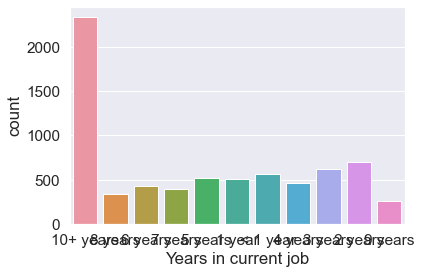

In [199]:
sns.countplot(x="Years in current job", data=df)
plt.show()

<AxesSubplot:xlabel='Years in current job', ylabel='count'>

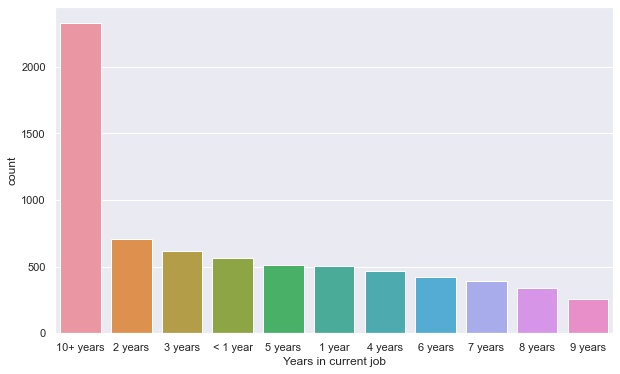

In [200]:
# посмотрим как выглядит распределение стажа
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df['Years in current job'], order = df['Years in current job'].value_counts().index)

In [201]:
df['Years in current job'] = df['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 11



df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 11

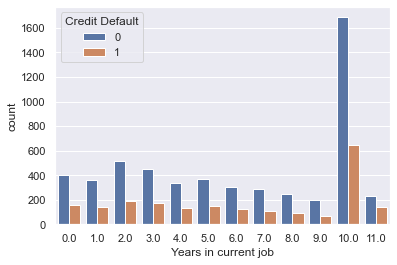

In [202]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df)
plt.show()

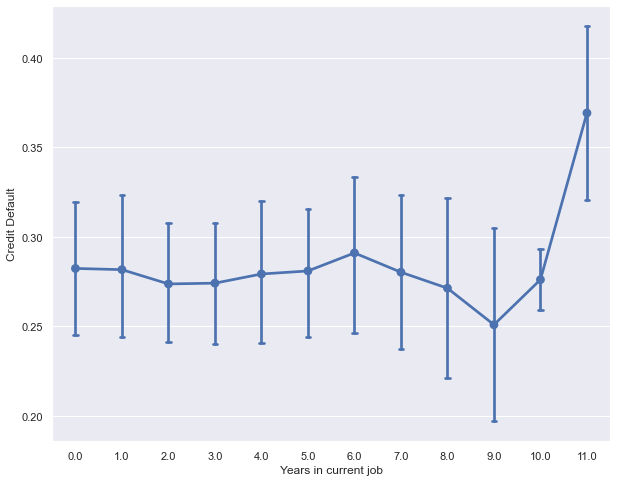

In [203]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Years in current job', y='Credit Default', data=df, capsize=.1,);

## Tax Liens - налоговые обременения<a name="4_feature"></a>

[Обзор данных](#index)

In [204]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

## Number of Open Accounts - количество открытых счетов<a name="5_feature"></a>

[Обзор данных](#index)

In [210]:
df['Number of Open Accounts'].describe()

count    7500.000000
mean       10.446667
std         3.827485
min         2.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        20.000000
Name: Number of Open Accounts, dtype: float64

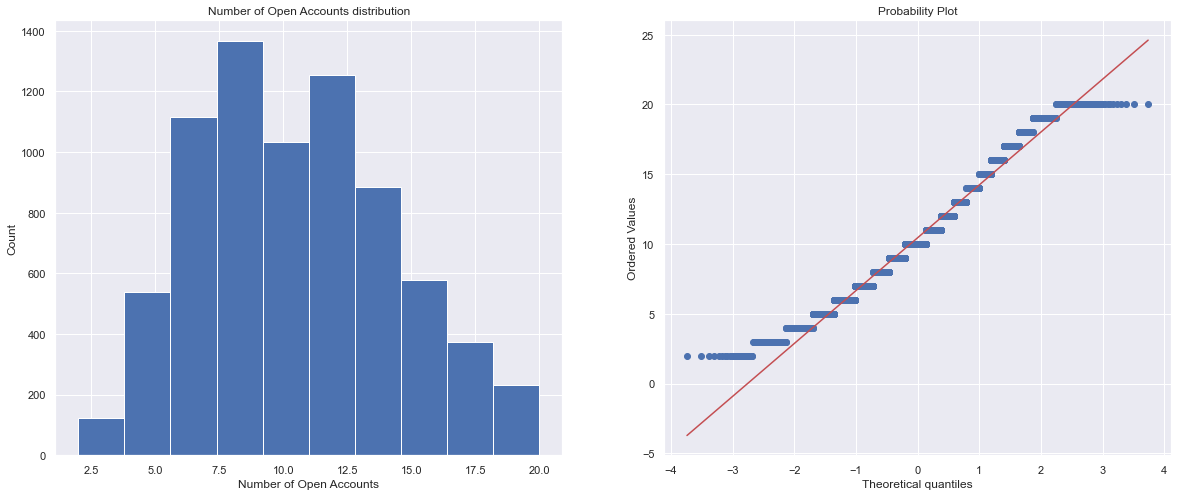

In [212]:
hist_qq('Number of Open Accounts')

In [213]:
df.loc[(df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.95)), :].shape

(375, 22)

In [214]:
df.loc[df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.95), ['Number of Open Accounts']] =\
            df['Number of Open Accounts'].median()

df_test.loc[df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.95),  \
            ['Number of Open Accounts']] = df_test['Number of Open Accounts'].median()

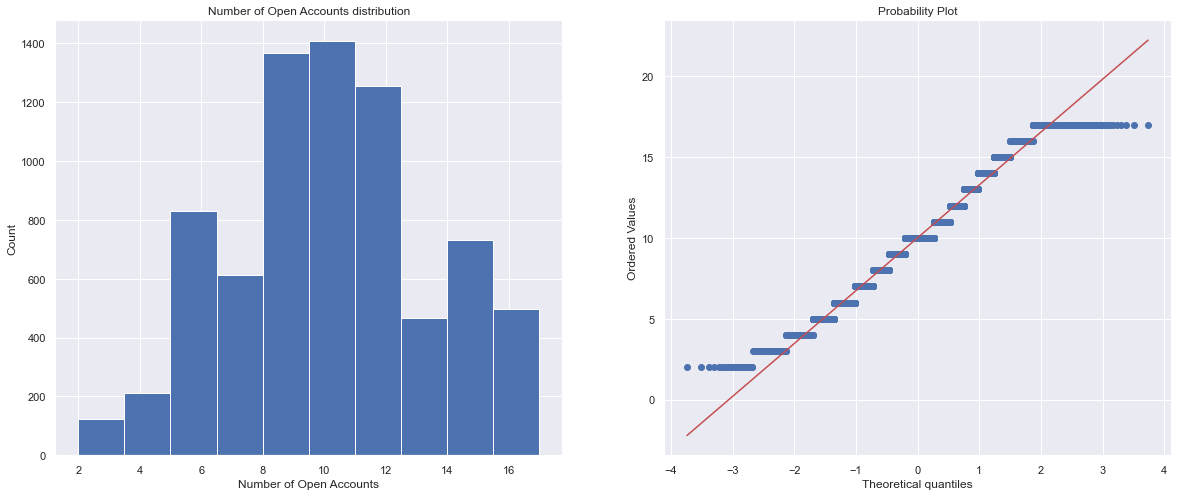

In [215]:
hist_qq('Number of Open Accounts')

## Years of Credit History - количество лет кредитной истории<a name="6_feature"></a>

[Обзор данных](#index)

In [216]:
df['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.5      1
50.0      1
40.1      1
51.5      1
41.6      1
Name: Years of Credit History, Length: 408, dtype: int64

<AxesSubplot:>

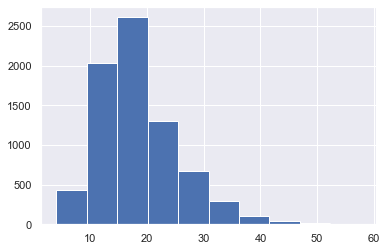

In [217]:
df['Years of Credit History'].hist()

In [218]:
# Все, что больше 40 лет кредитной истории заменяем на 40

df.loc[df['Years of Credit History'] > 40, ['Years of Credit History']] = 40

df_test.loc[df_test['Years of Credit History'] > 40, ['Years of Credit History']] = 40

<AxesSubplot:>

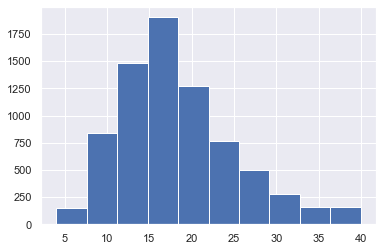

In [219]:
df['Years of Credit History'].hist()

## Maximum Open Credit - наибольший открытый кредит<a name="7_feature"></a>

[Обзор данных](#index)

In [220]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

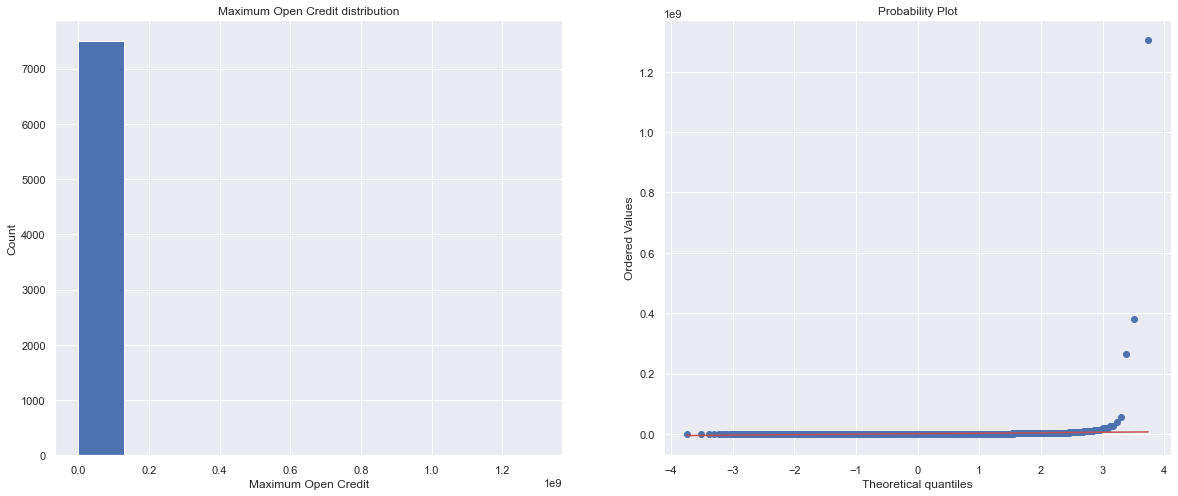

In [221]:
hist_qq('Maximum Open Credit')

In [222]:
# df.loc[(df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95)), :].shape

In [223]:
df.loc[df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df['Maximum Open Credit'].quantile(.95)

df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].quantile(.95)

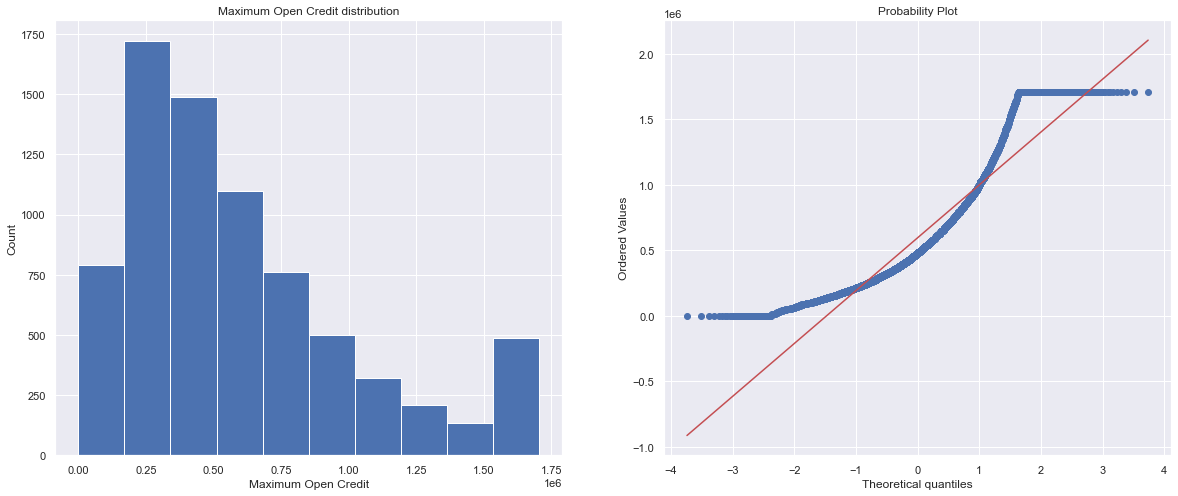

In [224]:
hist_qq('Maximum Open Credit')

## Number of Credit Problems - количество проблем с кредитом<a name="8_feature"></a>

[Обзор данных](#index)

In [225]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

## Months since last delinquent - количество месяцев с последней просрочки кредита<a name="9_feature"></a>

[Обзор данных](#index)

In [226]:
 df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

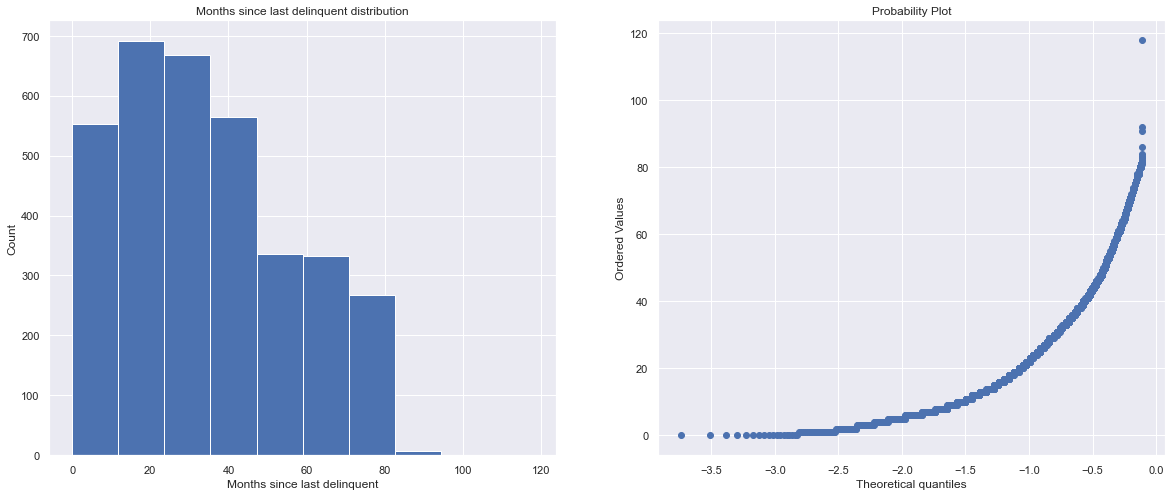

In [227]:
hist_qq('Months since last delinquent')

In [228]:
df['Months since last delinquent NULL'] = df['Months since last delinquent'].isnull()
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
# df['Months since last delinquent'].fillna(0, inplace=True)

df_test['Months since last delinquent NULL'] = df_test['Months since last delinquent'].isnull()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

## Bankruptcies - банкротства<a name="10_feature"></a>

[Обзор данных](#index)

In [229]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [230]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

## Purpose - цель кредита<a name="11_feature"></a>

[Обзор данных](#index)

In [231]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [232]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

<AxesSubplot:title={'center':'Purpose'}>

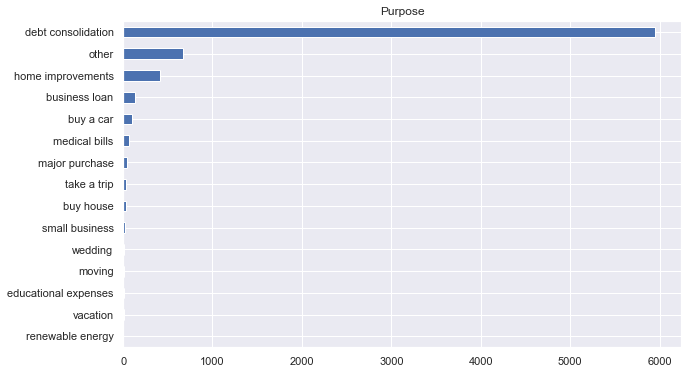

In [233]:
df['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

<AxesSubplot:title={'center':'Purpose / Credit Default'}, xlabel='Purpose'>

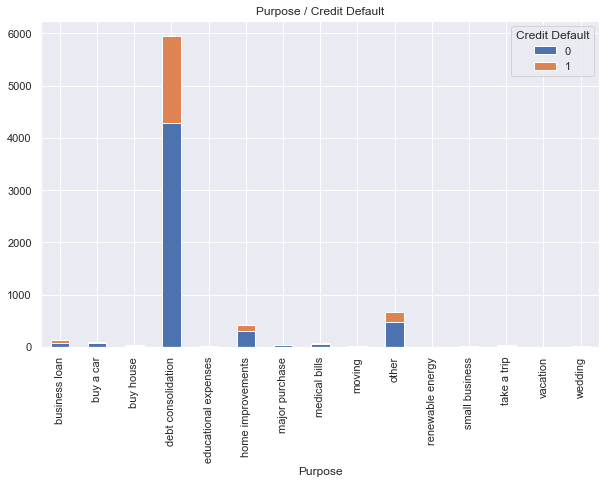

In [234]:
purpose_cr_deafult = df[['Purpose','Credit Default']]
pd.crosstab(purpose_cr_deafult['Purpose'], purpose_cr_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(10,6), title="Purpose / Credit Default", )

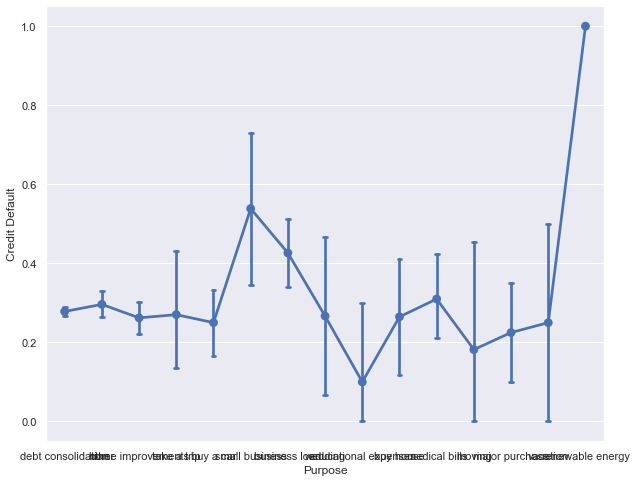

In [235]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

In [236]:
# df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
# df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'], prefix='Purpose')], axis=1)

In [237]:
# по графику видно, что можно можно разделить всего на 4 категории

df['Purpose'] = df['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

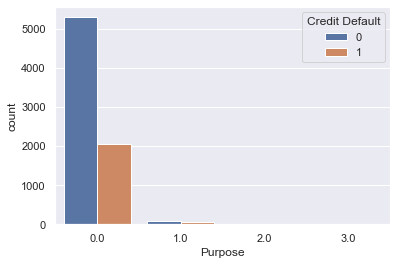

In [238]:
 sns.countplot(x="Purpose", hue='Credit Default', data=df)
 plt.show()

## Term - срок кредита<a name="12_feature"></a>

[Обзор данных](#index)

In [239]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

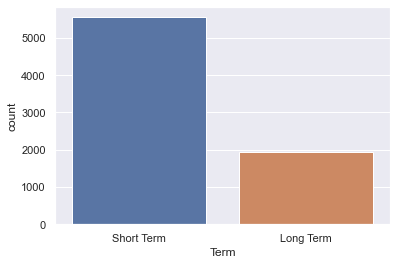

In [240]:
sns.countplot(x="Term", data=df)
plt.show()

In [241]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

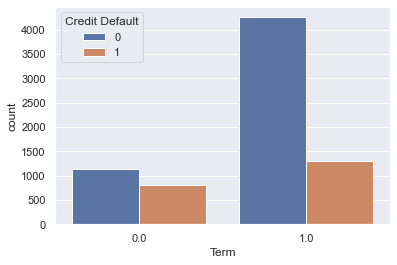

In [242]:
sns.countplot(x="Term", hue='Credit Default', data=df)
plt.show()

In [243]:
corr_('Term',0,1)

1.1519373940439208e-55


## Current Loan Amount - текущая сумма кредита<a name="13_feature"></a>

[Обзор данных](#index)

In [244]:
df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [245]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

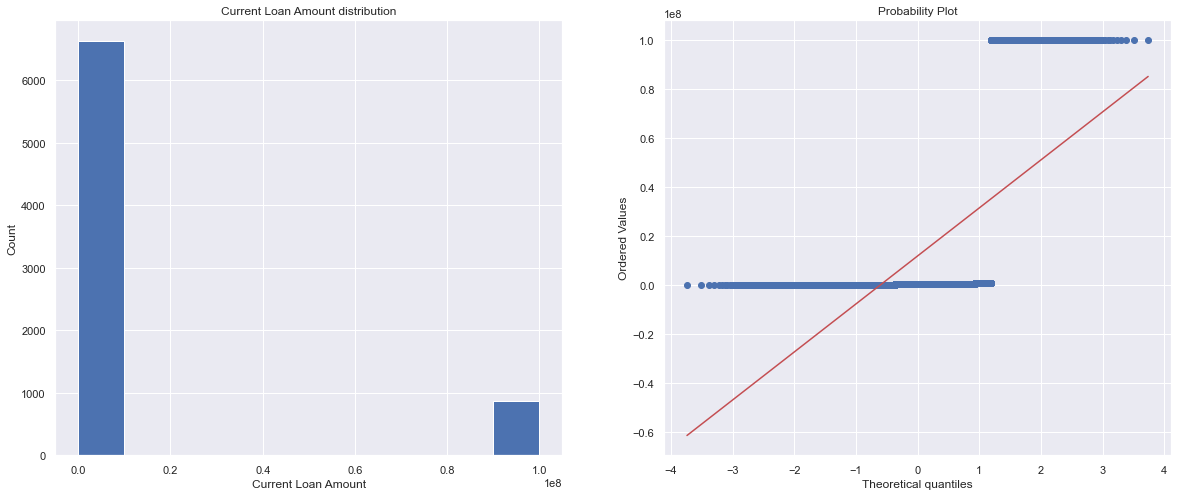

In [246]:
hist_qq('Current Loan Amount')

In [247]:
# вынос больших выбросов в отдельную переменную

df['Current Loan Amount BIG'] = df['Current Loan Amount'] == 99999999
df_test['Current Loan Amount BIG'] = df_test['Current Loan Amount'] == 99999999

In [248]:
df.loc[df['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None
df_test.loc[df_test['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None

In [249]:
df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].mean() #median()
df_test.loc[df_test['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean() #median()

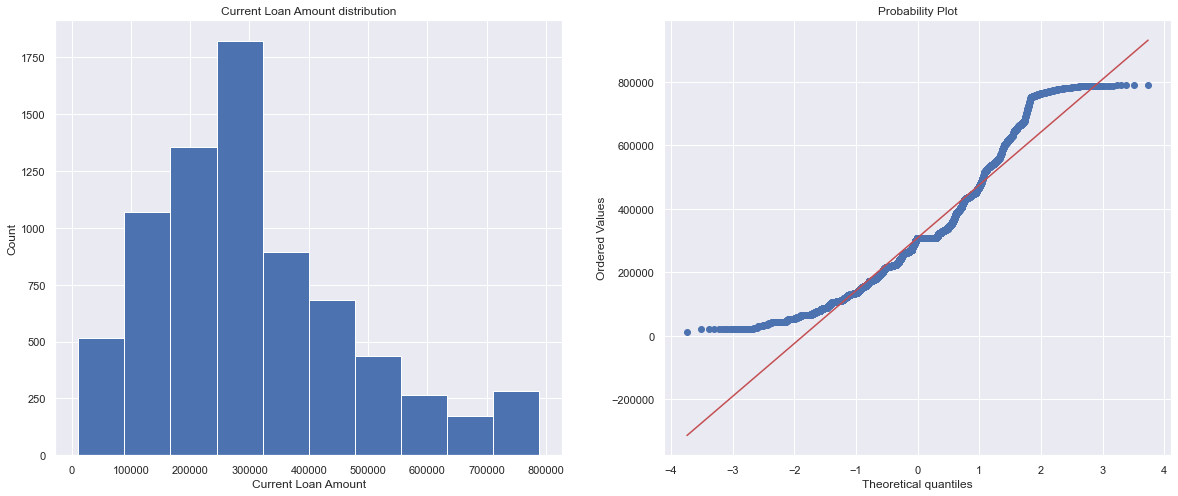

In [251]:
hist_qq('Current Loan Amount')

## Current Credit Balance - текущий кредитный баланс<a name="14_feature"></a>

[Обзор данных](#index)

In [253]:
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

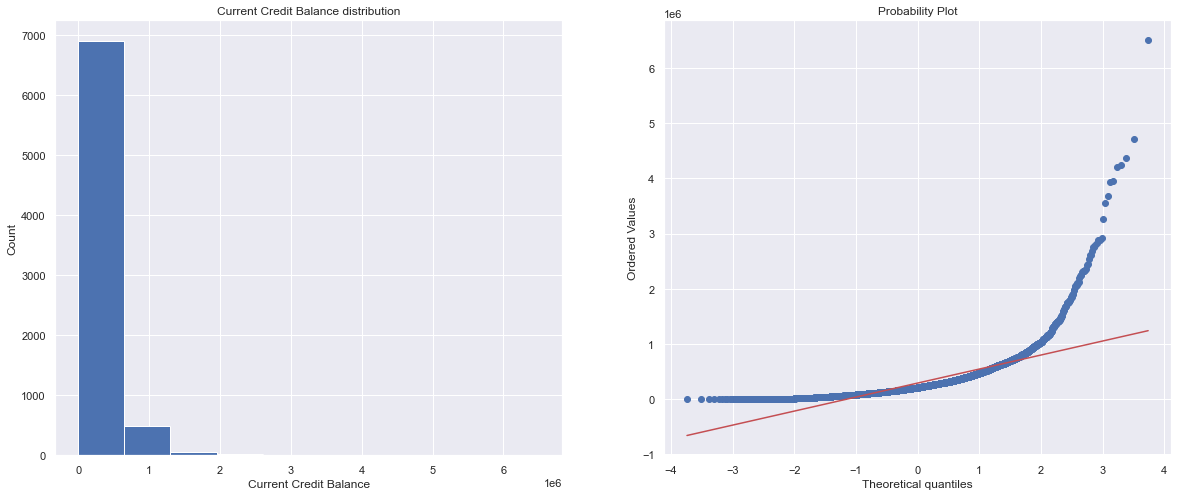

In [254]:
hist_qq('Current Credit Balance')

In [255]:
# выбросы

df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.95), :].shape

(375, 24)

In [256]:
df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df['Current Credit Balance'].quantile(.95) #df['Current Credit Balance'].mean()

df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].quantile(.95) #df_test['Current Credit Balance'].mean()

## Monthly Debt - ежемесячный долг<a name="15_feature"></a>

[Обзор данных](#index)

In [257]:
df['Monthly Debt'].value_counts()

0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
          ..
12857.0    1
10777.0    1
29267.0    1
25050.0    1
31119.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

<AxesSubplot:>

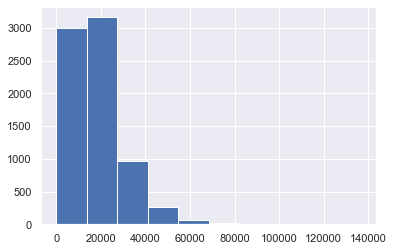

In [258]:
df['Monthly Debt'].hist()

<AxesSubplot:>

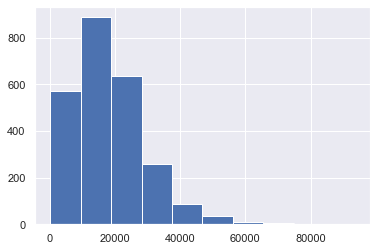

In [259]:
df_test['Monthly Debt'].hist()

In [260]:
df.loc[df['Monthly Debt'] > df['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df['Monthly Debt'].mean()

df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

<AxesSubplot:>

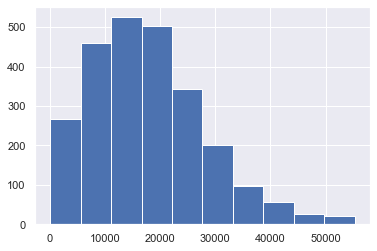

In [261]:
df_test['Monthly Debt'].hist()

## Credit Score - кредитный рейтинг<a name="16_feature"></a>

[Обзор данных](#index)

In [262]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

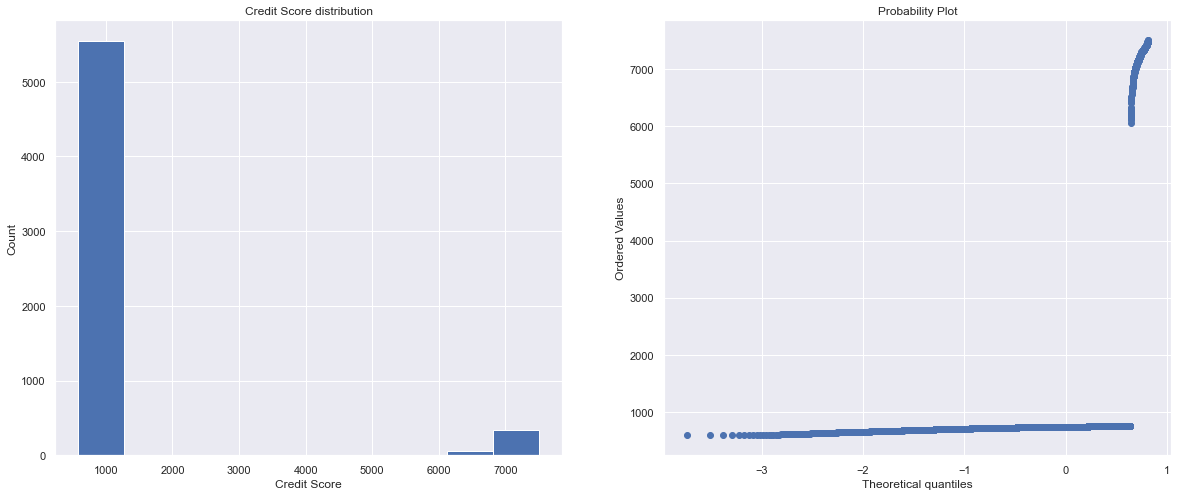

In [263]:
hist_qq('Credit Score')

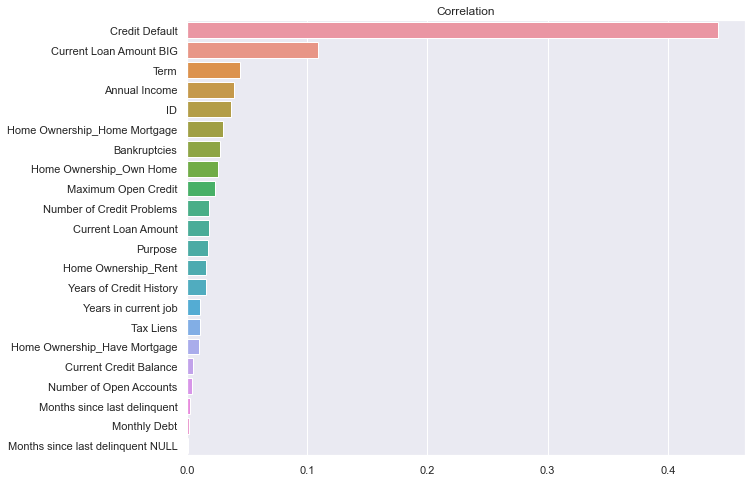

In [264]:
# посмотрим, как коррелируют признаки с 'Credit Score'

FEATURE_NAMES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = df[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

In [265]:
# для обучения выбираем 7 наиболее влияющих признаков (8-й признак имеет много null)
# TARGET_FEATURE = list(corr_Credit_Score.index[0:15])

TARGET_FEATURE = [
#                  'Credit Default',
                 'Current Loan Amount BIG',
                 'Current Loan Amount',
                 'Term',
                 'Annual Income',
#                  'ID',
                 'Home Ownership_Home Mortgage',
                 'Bankruptcies',
                 'Home Ownership_Own Home',
                 'Maximum Open Credit',
                 'Number of Credit Problems',
                 'Purpose',
                 'Home Ownership_Rent',
                 'Years of Credit History',
                 'Years in current job'
                 ]

In [266]:
# отбираем набор данных для обучения
data = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]#.sample(2000)
data

,Current Loan Amount BIG,Current Loan Amount,Term,Annual Income,Home Ownership_Home Mortgage,Bankruptcies,Home Ownership_Own Home,Maximum Open Credit,Number of Credit Problems,Purpose,Home Ownership_Rent,Years of Credit History,Years in current job,Credit Score
0,True,309024.390347,1.0,482087.0,0,1.0,1,685960.0,1.0,0.0,0,26.3,11.0,749.0
1,False,264968.000000,0.0,1025487.0,0,0.0,1,1181730.0,0.0,0.0,0,15.3,10.0,737.0
2,True,309024.390347,1.0,751412.0,1,0.0,0,1182434.0,0.0,0.0,0,35.0,8.0,742.0
3,False,121396.000000,1.0,805068.0,0,1.0,1,147400.0,1.0,0.0,0,22.5,6.0,694.0
4,False,125840.000000,1.0,776264.0,0,0.0,0,385836.0,1.0,0.0,1,13.6,8.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,False,437404.000000,1.0,2833185.0,1,0.0,0,280170.0,0.0,0.0,0,21.3,6.0,704.0
7493,False,448052.000000,0.0,1257610.0,0,0.0,0,821480.0,0.0,0.0,1,16.5,8.0,676.0
7495,False,129360.000000,1.0,402192.0,0,0.0,0,107866.0,0.0,0.0,1,8.5,0.0,697.0
7496,False,444048.000000,0.0,1533984.0,1,0.0,0,686312.0,0.0,0.0,0,26.5,1.0,7410.0


In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount BIG       5943 non-null   bool   
 1   Current Loan Amount           5943 non-null   float64
 2   Term                          5943 non-null   float64
 3   Annual Income                 5943 non-null   float64
 4   Home Ownership_Home Mortgage  5943 non-null   uint8  
 5   Bankruptcies                  5943 non-null   float64
 6   Home Ownership_Own Home       5943 non-null   uint8  
 7   Maximum Open Credit           5943 non-null   float64
 8   Number of Credit Problems     5943 non-null   float64
 9   Purpose                       5943 non-null   float64
 10  Home Ownership_Rent           5943 non-null   uint8  
 11  Years of Credit History       5943 non-null   float64
 12  Years in current job          5943 non-null   float64
 13  Cre

In [268]:
%%time

# учимся на Регрессии

model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

Wall time: 13.6 s


LogisticRegression()

In [269]:
# заполняем пропуски на основе обученной модели

df.loc[(df['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df_test.loc[(df_test['Credit Score'].isnull()), TARGET_FEATURE])

In [270]:
# смотрим, какое распределение получилось
shapiro(df['Credit Score'])

ShapiroResult(statistic=0.24974864721298218, pvalue=0.0)

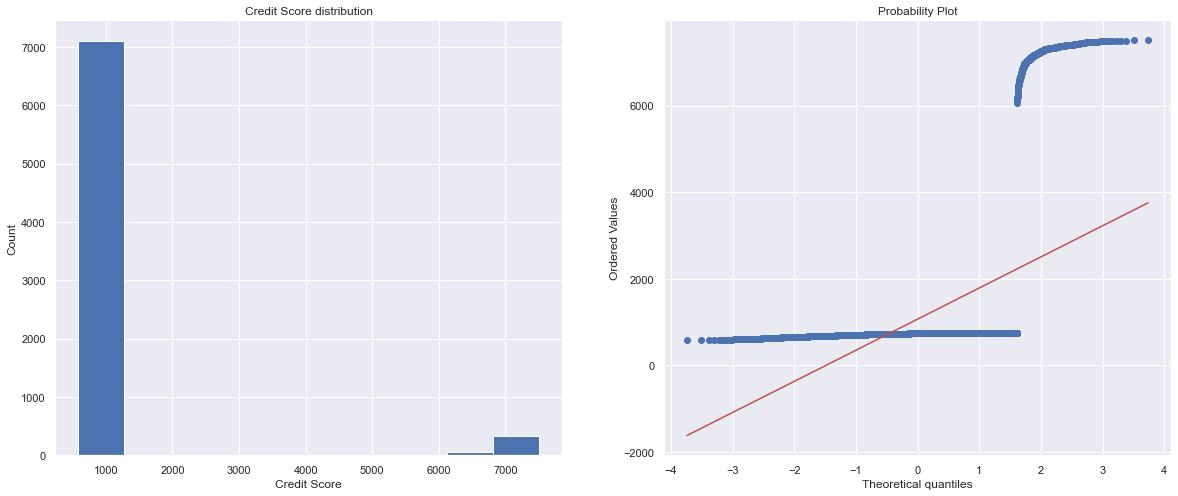

In [271]:
hist_qq('Credit Score')

In [272]:
df.loc[(df['Credit Score'] < 700), 'Credit Score'] = 0
df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 740), 'Credit Score'] = 1
# df.loc[(df['Credit Score'] >= 720) & (df['Credit Score'] < 740), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 740) & (df['Credit Score'] <= 750), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 750) & (df['Credit Score'] <= 800), 'Credit Score'] = 3
df.loc[(df['Credit Score'] > 800), 'Credit Score'] = 4

# df['Credit Score NULL'] = df['Credit Score'].isnull()
# df.loc[df['Credit Score'].isnull(), 'Credit Score'] = 4

# df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = df_test['Credit Score'].median()


df_test.loc[(df_test['Credit Score'] < 700), 'Credit Score'] = 0
df_test.loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 740), 'Credit Score'] = 1
df_test.loc[(df_test['Credit Score'] >= 740) & (df_test['Credit Score'] <= 750), 'Credit Score'] = 2
df_test.loc[(df_test['Credit Score'] >= 750) & (df_test['Credit Score'] <= 800), 'Credit Score'] = 3
df_test.loc[(df_test['Credit Score'] > 800), 'Credit Score'] = 4

# df_test['Credit Score NULL'] = df_test['Credit Score'].isnull()
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 4

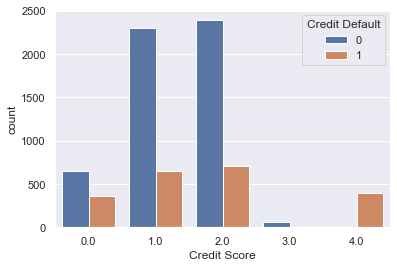

In [273]:
sns.countplot(x="Credit Score", hue='Credit Default', data=df)
plt.show()

## Новый признак<a name="new"></a>

[Обзор данных](#index)

In [277]:
df['No problems'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)
df_test['No problems'] = (df_test['Number of Credit Problems'] == 0) \
                                & (df_test['Bankruptcies'] == 0) & (df_test['Tax Liens'] == 0)

In [278]:
df['No problems'].value_counts()

True     6469
False    1031
Name: No problems, dtype: int64

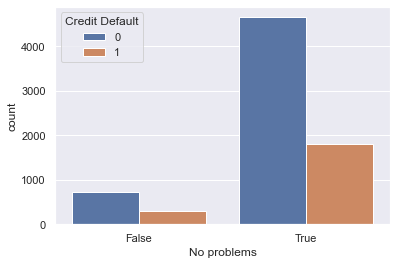

In [279]:
sns.countplot(x="No problems", hue='Credit Default', data=df)
plt.show()

## Обзор целевой переменной. Credit Default<a name="17_feature"></a>

[Обзор данных](#index)

In [280]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [281]:
# смотрим train
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Home Ownership                     7500 non-null   object 
 1   Annual Income                      7500 non-null   float64
 2   Years in current job               7500 non-null   float64
 3   Tax Liens                          7500 non-null   float64
 4   Number of Open Accounts            7500 non-null   float64
 5   Years of Credit History            7500 non-null   float64
 6   Maximum Open Credit                7500 non-null   float64
 7   Number of Credit Problems          7500 non-null   float64
 8   Months since last delinquent       7500 non-null   float64
 9   Bankruptcies                       7500 non-null   float64
 10  Purpose                            7500 non-null   float64
 11  Term                               7500 non-null   float

In [282]:
# выбираем рабочие столбцы
COL_SELECTED = [
    'Current Loan Amount BIG',
    'No problems',
    'Annual Income',
    'Years in current job',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Purpose',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score',
    'Home Ownership_Have Mortgage',
    'Home Ownership_Home Mortgage',
    'Home Ownership_Own Home',
    'Home Ownership_Rent' 
]          

In [283]:
# выбираем числовые столбцы (чтобы построить статистику)

COL_SELECTED_NUM = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
                         ]

Annual Income
MannwhitneyuResult(statistic=9364448.0, pvalue=0.466345140840377)


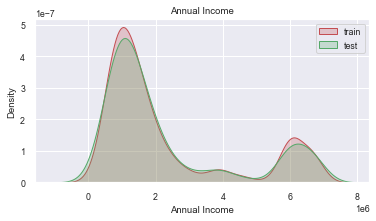

Years in current job
MannwhitneyuResult(statistic=9325493.5, pvalue=0.3434769891811027)


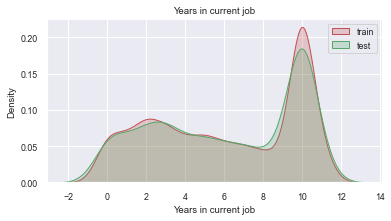

Number of Open Accounts
MannwhitneyuResult(statistic=9110102.5, pvalue=0.016580379680301058)


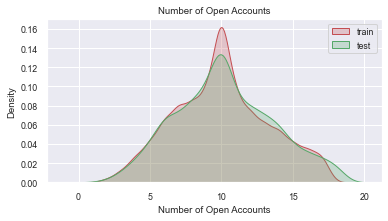

Years of Credit History
MannwhitneyuResult(statistic=9339686.0, pvalue=0.38878036831006235)


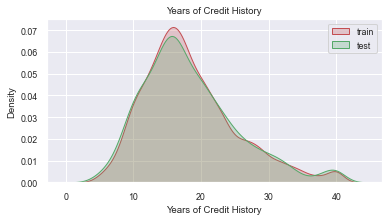

Maximum Open Credit
MannwhitneyuResult(statistic=9314533.5, pvalue=0.31429330558941404)


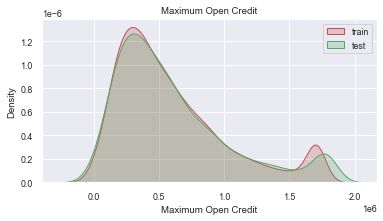

Current Loan Amount
MannwhitneyuResult(statistic=9074421.5, pvalue=0.008078991150053687)


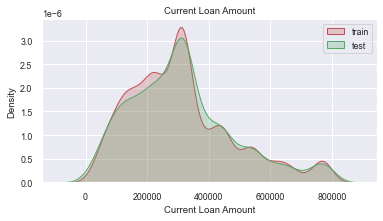

Current Credit Balance
MannwhitneyuResult(statistic=9307269.0, pvalue=0.2939671912978591)


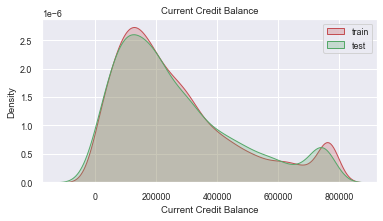

Monthly Debt
MannwhitneyuResult(statistic=9285486.0, pvalue=0.2369733356229915)


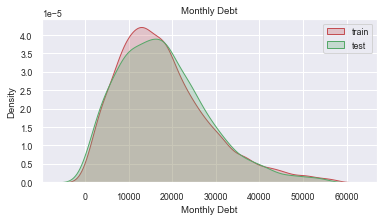

Credit Score
MannwhitneyuResult(statistic=9330460.0, pvalue=0.3510996470507005)


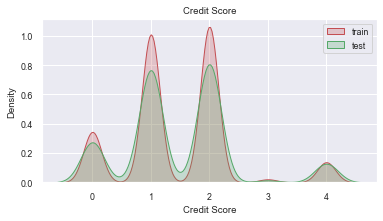

In [284]:
# смотрим похоже-ли распределение непрерывных показателей на train и test

from scipy.stats import mannwhitneyu

# p > 5% - распределения похожи
figsize = (6, 3)
for col in COL_SELECTED_NUM:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

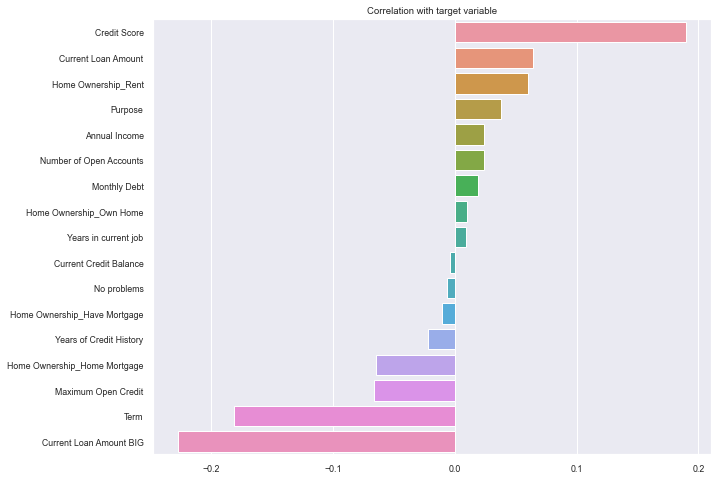

In [285]:
# смотрим влияния столбцов на целевой признак

corr_with_target = df[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

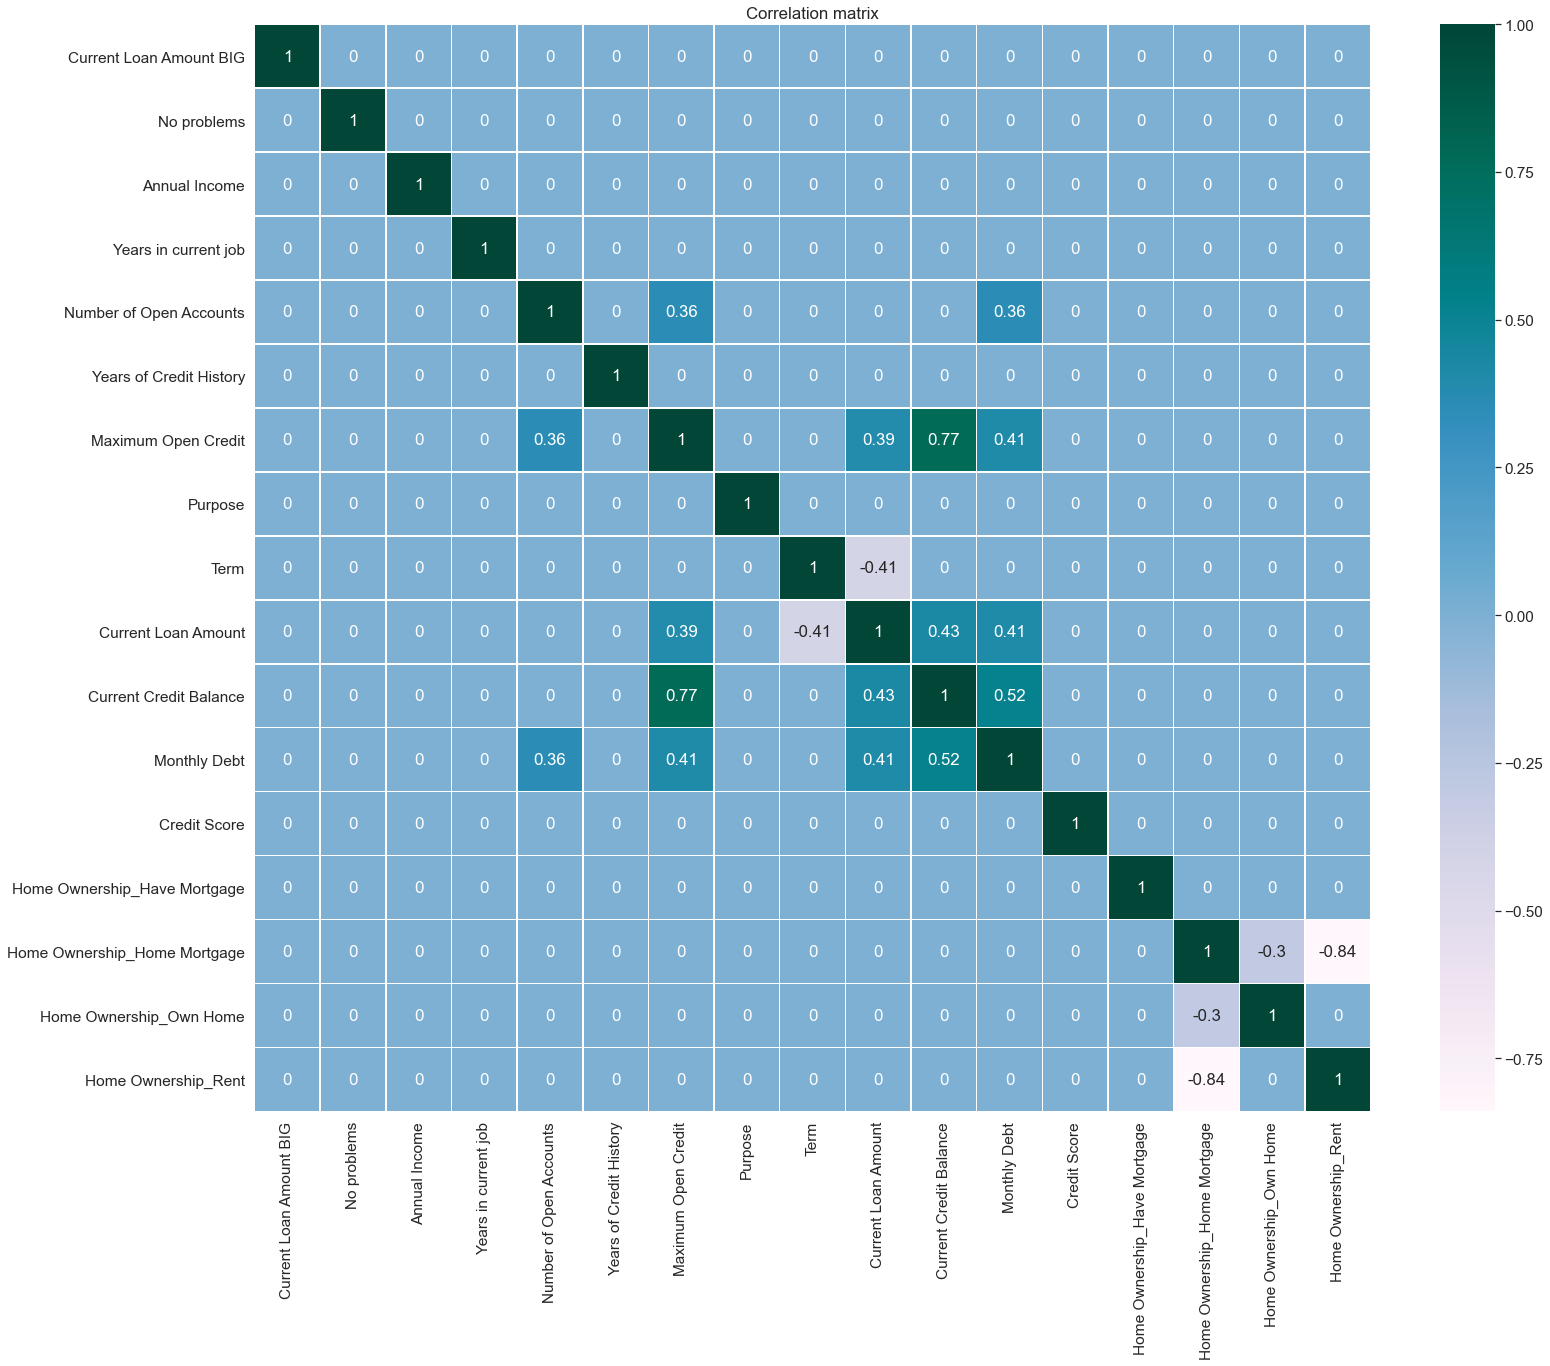

In [287]:
# матрица корреляции

plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[COL_SELECTED].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='PuBuGn')

plt.title('Correlation matrix')
plt.show()

## Разбиение на train и test. Балансировка целевой переменной. 

[Обзор данных](#index)

In [288]:
# Масштабируем данные
# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[COL_SELECTED_NUM] = scaler.fit_transform(df_norm[COL_SELECTED_NUM])

# df = df_norm.copy()
# Масштабировать не будем, не улучшает результат

X = df[COL_SELECTED]
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,  test_size=0.30, random_state=21)
#                                                     stratify=y,

In [289]:
# балансировка не дает прироста результатат поэтому отключена

# посмотрим как сбалансирована целевая переменная
# disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
# disbalance

In [290]:
# # Балансировка целевой переменной

# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
# df_balanced['Credit Default'].value_counts()

In [291]:
# X_train = df_balanced.drop(columns='Credit Default')
# y_train = df_balanced['Credit Default']

In [292]:
# disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
# disbalance

## Обучение на моделях

[Обзор данных](#index)

In [293]:
def pred_model(model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    print(model, '  --  ', f1_score(y_test, y_test_pred))
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)    

## Настройка модели CatBoost

In [294]:
 frozen_params = {
      'class_weights':[1, 3.3], 
      'silent':True,
      'random_state':21,
# #      'cat_features':CAT_FEATURE_NAMES,
      'eval_metric':'F1',
      'early_stopping_rounds':20
 }

In [295]:
 def evaluate_preds(model, X_train, X_test, y_train, y_test):
     y_train_pred = model.predict(X_train)
     y_test_pred = model.predict(X_test)

     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [296]:
 model = catb.CatBoostClassifier(**frozen_params,
                                 iterations=300,
                                 max_depth=7, 
 #                                 l2_leaf_reg=.5,
                                 reg_lambda=0.5
                                 )

 model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
 evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.59      0.71      3771
           1       0.44      0.83      0.58      1479

    accuracy                           0.66      5250
   macro avg       0.67      0.71      0.64      5250
weighted avg       0.77      0.66      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.56      0.68      1616
           1       0.41      0.80      0.55       634

    accuracy                           0.63      2250
   macro avg       0.65      0.68      0.61      2250
weighted avg       0.75      0.63      0.64      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               904  712
1               129  505


In [297]:
 params = {
     'reg_lambda': np.linspace(0.1, 4, 80)
 }

In [298]:
 model = catb.CatBoostClassifier(**frozen_params,
                                 iterations=300,
                                 max_depth=7)

In [299]:
 cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [300]:
 grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7497852011
bestIteration = 25

0:	loss: 0.7497852	best: 0.7497852 (0)	total: 408ms	remaining: 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7365447078
bestIteration = 3

1:	loss: 0.7365447	best: 0.7497852 (0)	total: 606ms	remaining: 14.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7434372716
bestIteration = 17

2:	loss: 0.7434373	best: 0.7497852 (0)	total: 989ms	remaining: 15.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7393718864
bestIteration = 25

3:	loss: 0.7393719	best: 0.7497852 (0)	total: 1.45s	remaining: 16.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7442061304
bestIteration = 34

4:	loss: 0.7442061	best: 0.7497852 (0)	total: 2.01s	remaining: 18.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7506781498
bestIteration = 29

5:	loss: 0.7506781	best: 0.7506781 (5)	total: 2.4s	remaining: 17

In [301]:
 grid_search

{'params': {'l2_leaf_reg': 2.8151898734177214},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
   

In [302]:
 %%time

 evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.74      0.83      3771
           1       0.58      0.91      0.71      1479

    accuracy                           0.79      5250
   macro avg       0.76      0.82      0.77      5250
weighted avg       0.85      0.79      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.64      0.73      1616
           1       0.44      0.71      0.54       634

    accuracy                           0.66      2250
   macro avg       0.64      0.67      0.63      2250
weighted avg       0.73      0.66      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1034  582
1                185  449
Wall time: 76.1 ms


In [303]:
 def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

     #Determines cross-validated training and test scores for different training set sizes.
     train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                             cv=cv, 
                                                             scoring='f1',
                                                             train_sizes=train_sizes, 
                                                             n_jobs=n_jobs)
     train_scores_mean = np.mean(train_scores, axis=1)
     train_scores_std = np.std(train_scores, axis=1)
     test_scores_mean = np.mean(test_scores, axis=1)
     test_scores_std = np.std(test_scores, axis=1)

     plt.figure(figsize=(15,8))
     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

     plt.title(f"Learning curves ({type(estimator).__name__})")
     plt.xlabel("Training examples")
     plt.ylabel("Score")     
     plt.legend(loc="best")
     plt.grid()
     plt.show()

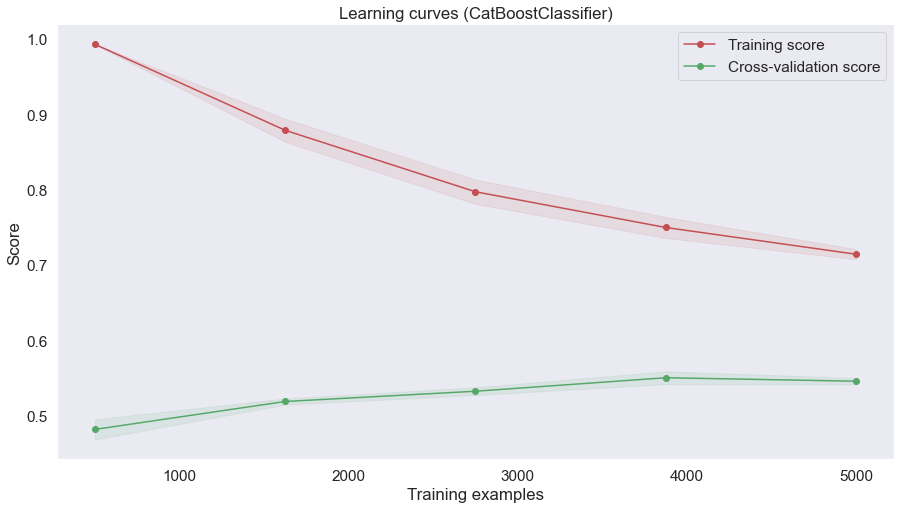

In [304]:
 show_learning_curve_plot(model, X, y)

In [305]:
 def show_feature_importances(feature_names, feature_importances, get_top=None):
     feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
     feature_importances = feature_importances.sort_values('importance', ascending=False)
       
     plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
     sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
     plt.xlabel('Importance')
     plt.title('Importance of features')
     plt.show()
    
     if get_top is not None:
       return feature_importances['feature'][:get_top].tolist()

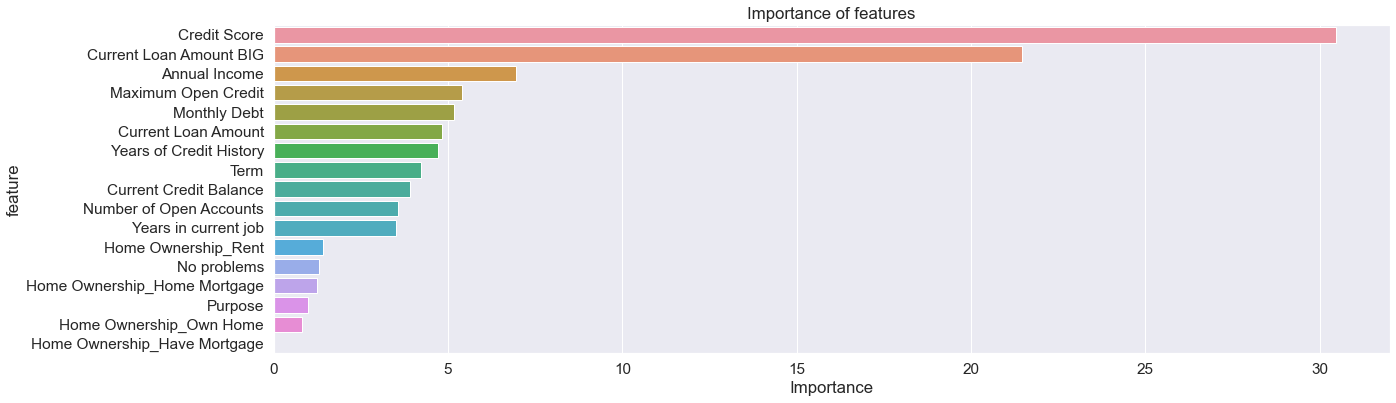

In [306]:
 important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

In [307]:
 important_features_top

['Credit Score',
 'Current Loan Amount BIG',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Loan Amount',
 'Years of Credit History',
 'Term',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job',
 'Home Ownership_Rent',
 'No problems',
 'Home Ownership_Home Mortgage',
 'Purpose',
 'Home Ownership_Own Home',
 'Home Ownership_Have Mortgage']

In [308]:
 %%time

 frozen_params = {
      'class_weights':[1, 3.1], 
      'silent':True,
      'random_state':21,
 #      'cat_features':NEW_CAT_FEATURE_NAMES,
      'eval_metric':'F1',
      'early_stopping_rounds':20
 }

 final_model = catb.CatBoostClassifier(**frozen_params,
                                       iterations=300,
                                       max_depth=7,
                                       reg_lambda=0.5)

 final_model.fit(X_train[important_features_top], y_train)

 evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      3771
           1       0.64      0.90      0.74      1479

    accuracy                           0.83      5250
   macro avg       0.79      0.85      0.81      5250
weighted avg       0.86      0.83      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1616
           1       0.45      0.63      0.53       634

    accuracy                           0.68      2250
   macro avg       0.64      0.66      0.64      2250
weighted avg       0.72      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1126  490
1                233  401
Wall time: 2.89 s


## Смотрим другие модели и используем VotingClassifier

In [309]:
for model in [
#             Логистическая регрессия
            LogisticRegression(C = 0.1, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50),     
            xgb.XGBClassifier(eval_metric="logloss", max_depth=50, reg_lambda=1, random_state=21),
            KNeighborsClassifier(), # К-ближайших соседей
            BaggingClassifier(), # Беггинг
            RandomForestClassifier(), # Случайный лес    
#             Дерево решений
            DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:3.3}, max_depth=4),
            lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21),
            catb.CatBoostClassifier(class_weights=[1, 3.3], silent=True),
            AdaBoostClassifier(),    
            SVC(C=0.05, kernel='rbf'), # Метод опорных векторов
            GaussianNB(),
            ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced'),
            GradientBoostingClassifier(learning_rate=7, random_state=42), # Бустинг
            Perceptron(class_weight='balanced')    
]:
        pred_model(model)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',
                   solver='liblinear')   --   0.4984765386959172
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=50, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)   --   0.44573643410852715
KNeighborsClassifier()   --   0.2523076923076923
BaggingClassifier()   --   0.44053774560496384
RandomForestClassifier()   --   0.4394110985277463
DecisionTreeClassifier(class_weight={0: 1, 1: 3.3}, max_depth=

In [310]:
# ансамбль на лучших моделях

model_vote = VotingClassifier(
    estimators=[
#         ('Logistic Regression', 
#                  LogisticRegression(C = 5, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50)),
#         ('XGBoost', xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=21)),
#         ('K-Neighbours', KNeighborsClassifier()),
#         ('DecisionTree', DecisionTreeClassifier(random_state=21,
#                                     class_weight={0:1, 1:3.6},
#                                     max_depth=4
#                                     )),
        ('LightGBM', lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21)),
        ('CatBooster', 
                            catb.CatBoostClassifier(class_weights=[1, 3.3], 
                                    depth=3,
                                    iterations=400,
#                                     l2_leaf_reg=300,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
#                                     random_state=21
                                    )),
#         ('Ada Boost', AdaBoostClassifier()),
#         ('SVM', SVC()),
#         ('Naive Bayes', GaussianNB()),
        ('Extra Tree', 
                ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced')),
#         ('Gradient Boosting', GradientBoostingClassifier(learning_rate=7, random_state=42)),
#         ('Perceptron', Perceptron(class_weight='balanced'))
    ],
#     voting='hard',
    voting='soft', # в этом случае вероятности суммируются и в итоге берется чито-то вроде среднего
    weights=[1,1.5,1],
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

print('VOTE:: ')
print(f1_score(y_test, y_test_pred))
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

VOTE:: 
0.5459026494146642


In [311]:
# модель CatBoost

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.3],
                                    depth=3,
                                    iterations=400, 
#                                     l2_leaf_reg=300,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
#                                     random_state=21
                                    )

# frozen_params = {
#      'class_weights':[1, 3.3], 
#      'silent':True,
#      'random_state':21,
# #      'cat_features':CAT_FEATURE_NAMES,
#      'eval_metric':'F1',
#      'early_stopping_rounds':20
# }

# model_catb = catb.CatBoostClassifier(**frozen_params,
#                                 iterations=400,
#                                 max_depth=7, 
# #                                 depth=12,
# #                                 l2_leaf_reg=.5,
#                                 reg_lambda=0.5
#                                 )

model_catb.fit(X_train, y_train)
# model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

print('CatBoost: ')
print(f1_score(y_test, y_test_pred))
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoost: 
0.5426356589147286


In [312]:
# сохраняем результат
df_test['Credit Default'] = model_vote.predict(df_test[COL_SELECTED])
df_test["Credit Default"] = model_catb.predict(df_test[COL_SELECTED])

df_test['ID'] = df_test.index.tolist()
df_test['ID'] = df_test['ID']
df_test1 = df_test[['Credit Default', 'ID']]

df_test1.to_csv(r'C:\course_project\Vote.csv', index=False)
df_test1.to_csv(r'C:\course_project\Cat_best.csv', index=False)